In [11]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
from tqdm import tqdm

## Helping Functions

In [12]:
def countplot(df, col, rotate=False):
    """
    draw a countplot for given column 
    Input: dataframe and column
    Output: Countplot 
    """
    fig, ax = plt.subplots(figsize=(7,4))
    g = sns.countplot(df[col],order=df[col].value_counts().index.tolist())
    ax.set_title(col+ ' distribution')
    ylabels = ['{:,.0f}'.format(y) + 'K' for y in g.get_yticks()/1000]
    g.set_yticklabels(ylabels)
    if rotate:
        ax.tick_params(axis='x', rotation=90)
    plt.show()

In [13]:
def save_csv(list_of_dataframes, file_names):
    """
    Store csv for each dataframe 
    """
    for i, df in enumerate(list_of_dataframes):
        loc = 'data/' + str(file_names[i]) +'.csv'
        df.to_csv(loc,index_label=False )
    

## 1: Load Data:

In [15]:
profiles = pd.read_json('../starbuck_capstone/data/profile.json',orient='records',lines=True)
transcripts = pd.read_json('../starbuck_capstone/data/transcript.json',orient='records',lines=True)
promotions = pd.read_json('../starbuck_capstone/data/portfolio.json',orient='records',lines=True)

In [16]:
print('shape of profile:',profiles.shape)
print('shape of transcript:',transcripts.shape)
print('shape of promotions:',promotions.shape)

shape of profile: (17000, 5)
shape of transcript: (306534, 4)
shape of promotions: (10, 6)


## 2: Data Cleaning:

### 2.1: Transcript:

In [17]:
transcripts

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0
...,...,...,...,...
306529,b3a1272bc9904337b331bf348c3e8c17,transaction,{'amount': 1.5899999999999999},714
306530,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,{'amount': 9.53},714
306531,a00058cf10334a308c68e7631c529907,transaction,{'amount': 3.61},714
306532,76ddbd6576844afe811f1a3c0fbb5bec,transaction,{'amount': 3.5300000000000002},714


In [18]:
transcripts.event.value_counts()

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

__Issues:__
1. Transactions and offers are in single column. 
2. Time seems to bit out of order. 

1.Transactions and offers are in single column. 

In [19]:
def fetch_from_json(json):
    try:
        return json['amount']
    except(KeyError):
        if 'offer id' in json:
            return json['offer id']
        else:
            return json['offer_id']
    


def separate_tran_offer(df):
    df = df.copy()
    cols = ['offer received','offer viewed','offer completed']
    # add offer where col exist # 
    df.loc[df.event.isin(cols),"offer"] = (df.loc[df.event.isin(cols),"value"]).apply(fetch_from_json)
    # add amount where transaction exist #
    df.loc[df.event=='transaction',"amount"] = df.loc[df.event=='transaction',"value"].apply(fetch_from_json)
    df.drop(['value'],axis=1, inplace=True)
    return df

separate_tran_offer(transcripts).head(5)

,person,event,time,offer,amount
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN
2,e2127556f4f64592b11af22de27a7932,offer received,0,2906b810c7d4411798c6938adc9daaa5,NaN
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,fafdcd668e3743c1bb461111dcafc2a4,NaN
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN


2. Time seems to bit out of order. 

-------leave it for the moment-----

### 2.2: Promotions:

In [20]:
promotions

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


__Issues:__
1. Channels are in the form of list in a single column. 
2. Multiple columns such as diffculty, duration and offer type for a single promotion. 

1. Channels are in the form of list in a single column. 

In [21]:
def one_hot_channel(df):
    """
    create separate column for each channel
    Input: dataframe 
    Output: dataframe containing separate columns for each channel
    """
    # make a copy #
    df = df.copy()
    # create a list of all channels #
    channels = df.channels.max()
    # create separate column for each channel #
    for channel in channels:
        df[channel] = df['channels'].apply(lambda channels: 1 if channel in channels else 0)
    
    # drop the channels column # 
    df.drop(['channels'],axis=1,inplace=True)
    return df
        
one_hot_channel(promotions)

,reward,difficulty,duration,offer_type,id,web,email,mobile,social
0,10,10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,0,1,1,1
1,10,10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1
2,0,0,4,informational,3f207df678b143eea3cee63160fa8bed,1,1,1,0
3,5,5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,1,0
4,5,20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,1,0,0
5,3,7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2,1,1,1,1
6,2,10,10,discount,fafdcd668e3743c1bb461111dcafc2a4,1,1,1,1
7,0,0,3,informational,5a8bc65990b245e5a138643cd4eb9837,0,1,1,1
8,5,5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,1
9,2,10,7,discount,2906b810c7d4411798c6938adc9daaa5,1,1,1,0


2. Multiple columns such as diffculty, duration and offer type for a single promotion. 

In [22]:
def merge_cols_promotions(df):
    """
    merge columns (dfficulty, duration, reward and offer type) in single column 
    
    Input: dataframe 
    Output: dataframe contains a merge column for promotion 
    """
    # make a copy of the dataframe #
    df = df.copy()
    # merge columns # 
    df.loc[:,'promotion'] = df['offer_type'].astype(str)+'_'+df['reward'].astype(str)+'_'+ \
                                                df['difficulty'].astype(str)+'_'+df['duration'].astype(str)
    # drop the individual columns # 
    #df.drop(['reward','offer_type','duration','difficulty'],axis=1, inplace=True)
    return df 

merge_cols_promotions(promotions)


,reward,channels,difficulty,duration,offer_type,id,promotion
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,bogo_10_10_7
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo_10_10_5
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed,informational_0_0_4
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo_5_5_7
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount_5_20_10
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2,discount_3_7_7
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4,discount_2_10_10
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837,informational_0_0_3
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d,bogo_5_5_5
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5,discount_2_10_7


### 2.3: Profiles:

In [23]:
profiles

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN
...,...,...,...,...,...
16995,F,45,6d5f3a774f3d4714ab0c092238f3a1d7,20180604,54000.0
16996,M,61,2cb4f97358b841b9a9773a7aa05a9d77,20180713,72000.0
16997,M,49,01d26f638c274aa0b965d24cefe3183f,20170126,73000.0
16998,F,83,9dc1421481194dcd9400aec7c9ae6366,20160307,50000.0


In [24]:
profiles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
gender              14825 non-null object
age                 17000 non-null int64
id                  17000 non-null object
became_member_on    17000 non-null int64
income              14825 non-null float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.2+ KB


__Issues:__
1. Date is not in format (became member on). 
2. There are missing values in gender (as None), income (as NaN) and in some place is age is abnormal (for instance 118). 

1. Date is not in format (became member on). 

In [25]:
def convert_into_dateformat(df, col):
    """
    Function to convert date into pandas datatime format. 
    
    Input: dataframe and column (contain date)
    Output: dataframe containing date (date time format)
    """
    # make a copy of dataframe #
    df = df.copy()
    # convert it into string #
    df[col] = df[col].astype(str)
    df[col] = pd.to_datetime(df[col])
    
    return df

convert_into_dateformat(profiles,'became_member_on')

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,2018-07-12,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,2017-08-04,NaN
...,...,...,...,...,...
16995,F,45,6d5f3a774f3d4714ab0c092238f3a1d7,2018-06-04,54000.0
16996,M,61,2cb4f97358b841b9a9773a7aa05a9d77,2018-07-13,72000.0
16997,M,49,01d26f638c274aa0b965d24cefe3183f,2017-01-26,73000.0
16998,F,83,9dc1421481194dcd9400aec7c9ae6366,2016-03-07,50000.0


2. There are missing values in gender (as None), income (as NaN) and in some place is age is abnormal (for instance 118)

- gender:

In [26]:
round((profiles.gender.value_counts(dropna=False)/len(profiles))*100,2)

M      49.91
F      36.05
NaN    12.79
O       1.25
Name: gender, dtype: float64

- income:

In [27]:
round((profiles.income.isnull().sum()/len(profiles))*100,2)

12.79

- age:

In [28]:
round((((profiles.age > 100).sum())/len(profiles))*100,2)

12.82

__Observation__:

- income and geneder are about 12.7% missing. 
- age is slightly higher than the rest of two which is 12.8%. (although they aren't missing they just have value greater than 100). 

-----leave it for the moment---

## 3. Data Integration: 

In [29]:
def merge_data(profile_dt, transcript_dt, promotions_dt):
    """
    Function to merge all three datasets (profiles, promotions and transcripts)
    
    Input: dataframe for profiles, promotions and transcripts 
    Output: merged dataframe
    """
    profile_dt = profile_dt.copy()
    transcript_dt = transcript_dt.copy()
    promotions_dt = promotions_dt.copy()
    # 1. cleaning of datasets: 
    
    # clean transcript data #
    transcript_dt = separate_tran_offer(transcript_dt)
    # clean promotions data #
    promotions_dt = one_hot_channel(promotions_dt)
    promotions_dt = merge_cols_promotions(promotions_dt)
    # clean profile data #
    profile_dt = convert_into_dateformat(profile_dt,'became_member_on')
    
    # merge datasets: 
    
    # merge transcript and promotions # 
    trans_pro_dt = transcript_dt.merge(promotions_dt,how="left", left_on="offer", right_on="id").drop('id', axis=1)
    # merge profile to the recent merged dataframe #
    trans_pro_profile_dt = trans_pro_dt.merge(profile_dt,how="left", left_on="person", right_on="id").drop('id', axis=1)
    
    return trans_pro_profile_dt

In [30]:
merged_dt = merge_data(profiles,transcripts,promotions)

In [31]:
merged_dt

,person,event,time,offer,amount,reward,difficulty,duration,offer_type,web,email,mobile,social,promotion,gender,age,became_member_on,income
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,5.0,5.0,7.0,bogo,1.0,1.0,1.0,0.0,bogo_5_5_7,F,75,2017-05-09,100000.0
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,5.0,20.0,10.0,discount,1.0,1.0,0.0,0.0,discount_5_20_10,None,118,2017-08-04,NaN
2,e2127556f4f64592b11af22de27a7932,offer received,0,2906b810c7d4411798c6938adc9daaa5,NaN,2.0,10.0,7.0,discount,1.0,1.0,1.0,0.0,discount_2_10_7,M,68,2018-04-26,70000.0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,fafdcd668e3743c1bb461111dcafc2a4,NaN,2.0,10.0,10.0,discount,1.0,1.0,1.0,1.0,discount_2_10_10,None,118,2017-09-25,NaN
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,10.0,10.0,5.0,bogo,1.0,1.0,1.0,1.0,bogo_10_10_5,None,118,2017-10-02,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
306529,b3a1272bc9904337b331bf348c3e8c17,transaction,714,NaN,1.59,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,M,66,2018-01-01,47000.0
306530,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,714,NaN,9.53,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,M,52,2018-04-08,62000.0
306531,a00058cf10334a308c68e7631c529907,transaction,714,NaN,3.61,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,F,63,2013-09-22,52000.0
306532,76ddbd6576844afe811f1a3c0fbb5bec,transaction,714,NaN,3.53,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,M,57,2016-07-09,40000.0


## 4. Data Visualization: 

1. `event` distribution. 

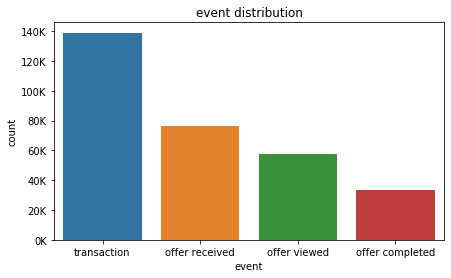

In [21]:
countplot(merged_dt, 'event')

2. Distribution of `amount`,`reward`,`difficulty` and `duration`

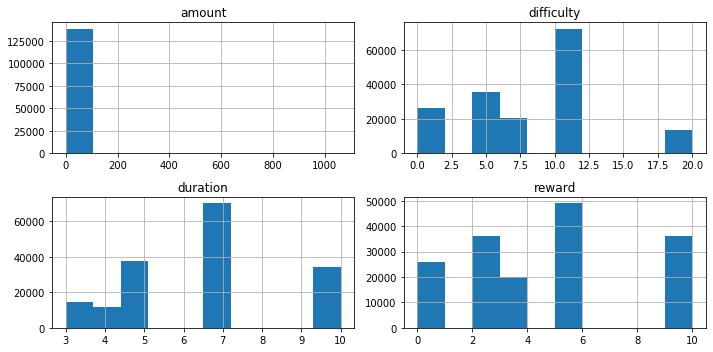

In [22]:
col = ['amount','reward','difficulty','duration']
merged_dt[col].hist(figsize=(10,5))
plt.tight_layout()

3. `offer type` distribution.

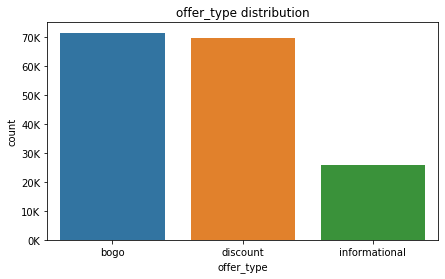

In [23]:
countplot(merged_dt, 'offer_type')

4. Distribtution of `offer recieved,viewed,completed` w.r.t `offer type`

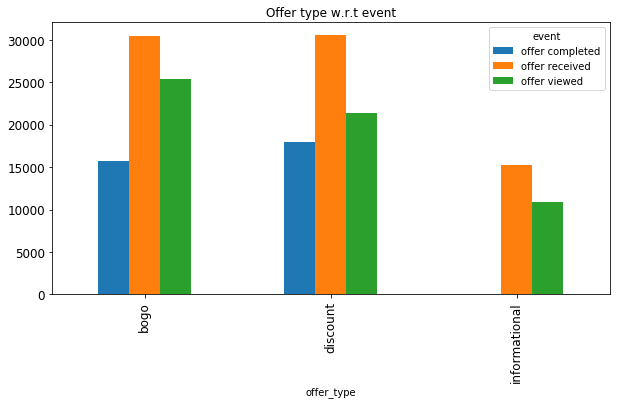

In [24]:
merged_dt.groupby(by=['offer_type','event']).size().unstack().plot(kind="bar",figsize=(10,5)\
                                                                   ,title='Offer type w.r.t event',fontsize=12)
plt.show()

As compared with discount, bogo offers have slightly less offer completed percentage. 

5. `promotion` distribution.

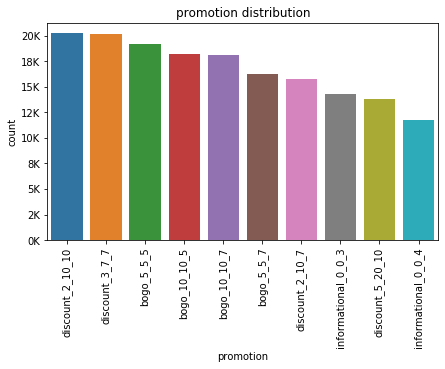

In [25]:
countplot(merged_dt, 'promotion',rotate=True)

6. Ratio of `promotions` `received`

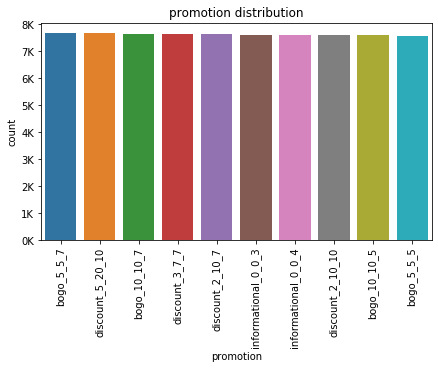

In [26]:
received = merged_dt[merged_dt['event']=='offer received']
countplot(received,'promotion',rotate=True)

All promotions have equal received ratio. 

7. Distribution of  `gender`,`age` and `income` 

In [27]:
cols = ['gender','age','income']

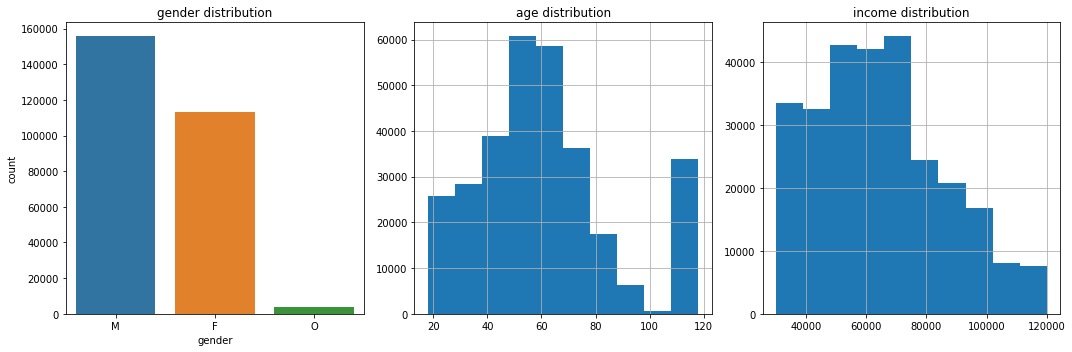

In [28]:
fig, ax = plt.subplots(ncols=3, figsize=(15,5))
# Visualization for the gender #
for i,col in enumerate(cols):
    if col=='gender':
        sns.countplot(merged_dt[col],ax=ax[i],order=merged_dt[col].value_counts().index.tolist())
        ax[i].set_title('gender distribution')
    else:
        merged_dt[col].hist(ax=ax[i])
        ax[i].set_title(str(col)+' distribution')
    plt.tight_layout()

1. Ratio: Male --> female and Other 
2. Age has an abnoral peak at 120. (Above 100 it doesn't make sense). 
3. income is nearly normal (bit right skewed -- some are earning more than many). 

8. `gender` with `income`

In [29]:
profiles = profiles[profiles['income'].notnull()]

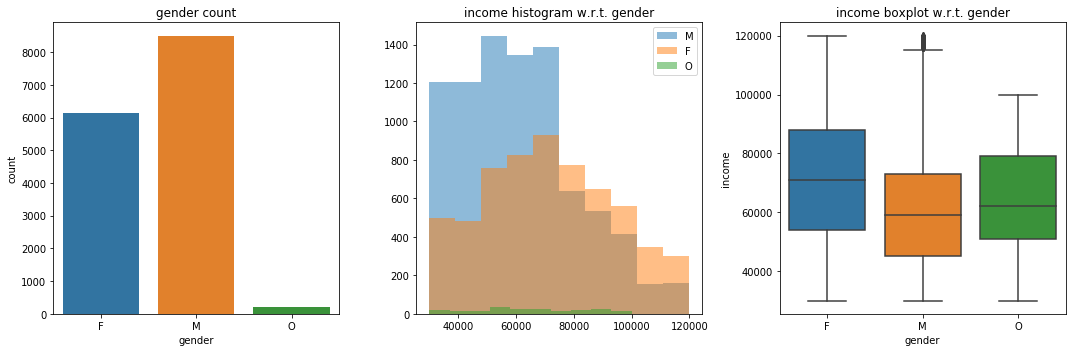

In [30]:
"""
Gender with income
"""

fig, ax = plt.subplots(ncols=3, figsize=(15,5))

# countplot of gender #
sns.countplot(profiles['gender'],ax=ax[0])
ax[0].set_title('gender count')

# histogram of income w.r.t income #
ax[1].hist(profiles[profiles.gender == 'M']['income'], alpha=0.5, label='M')
ax[1].hist(profiles[profiles.gender == 'F']['income'], alpha=0.5, label='F')
ax[1].hist(profiles[profiles.gender == 'O']['income'], alpha=0.5, label='O')
ax[1].set_title('income histogram w.r.t. gender')
ax[1].legend()

# boxplot of income w.r.t to income #
sns.boxplot(profiles['gender'], profiles['income'],ax=ax[2])
ax[2].set_title('income boxplot w.r.t. gender')

plt.tight_layout()
plt.show()

1. males have high income compared to females. 
2. Average income of females and others are higher than males. 

9. `gender` with `spending`

In [31]:
transactions = merged_dt[merged_dt['event']=='transaction'].copy()

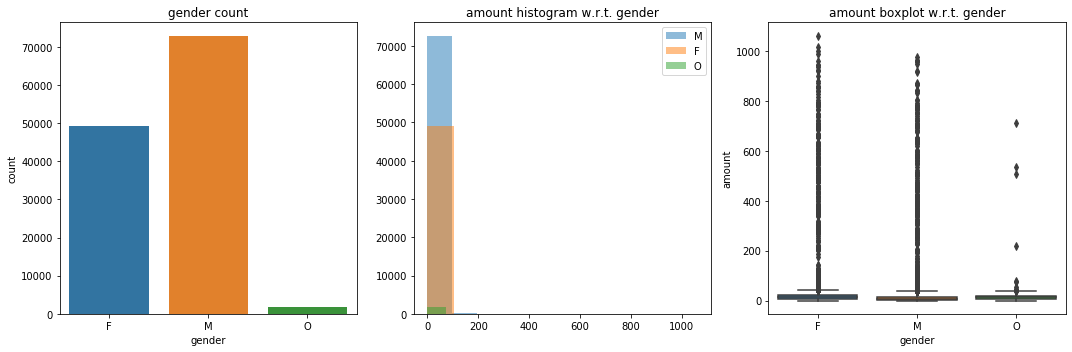

In [32]:
"""
Gender With Spending 
"""
fig, ax = plt.subplots(ncols=3, figsize=(15,5))

# countplot of gender #
sns.countplot(transactions['gender'],ax=ax[0])
ax[0].set_title('gender count')

# histogram of income w.r.t income #
ax[1].hist(transactions[transactions.gender == 'M']['amount'], alpha=0.5, label='M')
ax[1].hist(transactions[transactions.gender == 'F']['amount'], alpha=0.5, label='F')
ax[1].hist(transactions[transactions.gender == 'O']['amount'], alpha=0.5, label='O')
ax[1].set_title('amount histogram w.r.t. gender')
ax[1].legend()

# boxplot of income w.r.t to income #
sns.boxplot(transactions['gender'], transactions['amount'],ax=ax[2])
ax[2].set_title('amount boxplot w.r.t. gender')

plt.tight_layout()
plt.show()

Nothing can be conclude from it. 

10. `gender` with `age`

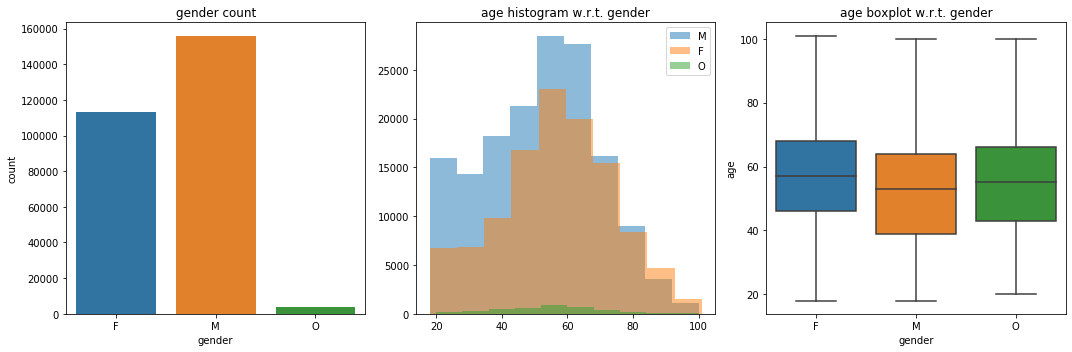

In [33]:
"""
Gender With age 
"""
fig, ax = plt.subplots(ncols=3, figsize=(15,5))

# countplot of gender #
sns.countplot(merged_dt['gender'],ax=ax[0])
ax[0].set_title('gender count')

# histogram of income w.r.t income #
ax[1].hist(merged_dt[merged_dt.gender == 'M']['age'], alpha=0.5, label='M')
ax[1].hist(merged_dt[merged_dt.gender == 'F']['age'], alpha=0.5, label='F')
ax[1].hist(merged_dt[merged_dt.gender == 'O']['age'], alpha=0.5, label='O')
ax[1].set_title('age histogram w.r.t. gender')
ax[1].legend()

# boxplot of income w.r.t to income #
sns.boxplot(merged_dt['gender'], merged_dt['age'],ax=ax[2])
ax[2].set_title('age boxplot w.r.t. gender')

plt.tight_layout()
plt.show()

Not much of a difference in age of different genders. 

11. Distribution of `spending`

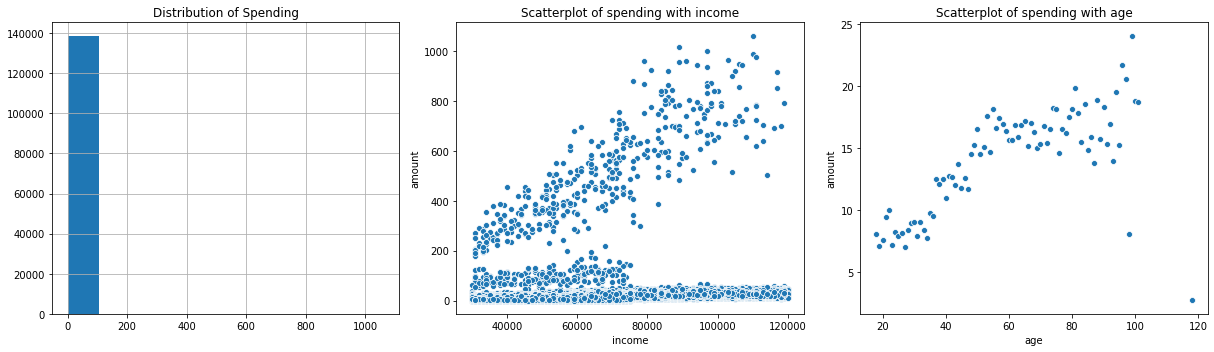

In [34]:
fig, ax = plt.subplots(ncols=3,figsize=(17,5))

# make a histogram of spending #
transactions.amount.hist(ax=ax[0])
ax[0].set_title('Distribution of Spending')

# make a scatterplot of  income vs spending # 
sns.scatterplot(x='income',y='amount',data=transactions,ax=ax[1])
ax[1].set_title('Scatterplot of spending with income')


# make a scatterplot of age vs avg spending #
agg = transactions.groupby(by=['age'])['amount'].mean().reset_index().rename(columns={'index':'age'})
sns.scatterplot(x='age',y='amount',data=agg,ax=ax[2])
ax[2].set_title('Scatterplot of spending with age')

plt.tight_layout()
plt.show()

- People at age 120 have quite weird trend of amount. 
- There seems to be a some sort of relationship between age and avg spending. (need further investigation). 
- There seems to be a some sort of relationship between income and income. (need further investigation)

13. `offer customer and regular` with `spending`

In [32]:
def find_customer_with_offer_type(df,transactions, event_type='offer completed'):
    """
    Find customers who have completed any offer and calculate their avg spending #
    """
    # make a copy #
    df = df.copy()
    # make a dataframe # 
    persons_df = pd.DataFrame(columns =['person','average spending'])
    # Those who completed the offer #
    persons = df[df['event']==event_type]['person'].unique()
    print(len(persons))
    # for each calculate the amount their avg spend #
    for person in persons:
        amount = transactions[transactions['person']==person]['amount'].mean()
        persons_df = persons_df.append({'person' : person , 'average spending' : amount} , ignore_index=True)
    return persons_df

#customer_comp_offer = find_customer_with_offer_type(merged_dt,transactions)

In [33]:
# find customer who didn't complete offer #
def find_regular_cutomers(df,transactions, offer_comp_persons):
    """
    Find regular customers and calulate their avg spending #
    """
    # make a copy #
    df = df.copy()
    # make a dataframe # 
    persons_df = pd.DataFrame(columns =['person','average spending'])
    # find regular customer #
    regular_customers = df[~df.person.isin(offer_comp_persons)]['person'].unique()
    print(len(regular_customers))
    # for each calculate the amount their avg spend #
    for person in regular_customers:
        amount = transactions[transactions['person']==person]['amount'].mean()
        persons_df = persons_df.append({'person' : person , 'average spending' : amount} , ignore_index=True)
    return persons_df

#offer_comp_persons_list = customer_comp_offer.person.unique()
#regular_customers = find_regular_cutomers(merged_dt,transactions,offer_comp_persons_list)

merge regular and offer customers:

In [37]:
customer_comp_offer['flag'] = "offer"
regular_customers['flag'] = "regular"

In [38]:
customers = pd.concat([customer_comp_offer,regular_customers],axis=0)

In [39]:
# fill NaN with 0 #
customers['average spending'] = customers['average spending'].fillna(0)

In [40]:
customers.groupby(by=['flag'])['average spending'].mean()

flag
offer      16.419439
regular     4.034437
Name: average spending, dtype: float64

There seems to be significant difference between avg spending of regular and offer customers. 

13. `offer received,viewed and completion rate` with respect to each customer. 

In [35]:
def event_statistics(df, customers, event_types):
    """
    Calculate statistics such as count, mean, median etc of different events for each customer 
    """
    try:
        event_stats = pd.read_csv('data/event_counts.csv')
    
    except:
        # make a copy # 
        df = df.copy()
        # make a dataframe #
        event_stats = pd.DataFrame(columns=['person'])
        # make a dictionary #
        event_dict = {}
        # calculate statistics of event type for each customer #
        for person in tqdm(customers):
            for event in event_types:
                event_dict[event] = df[(df['person']==person) & (df['event']==str(event))]['event'].count()
            event_dict['person'] = person
            event_stats = event_stats.append(event_dict , ignore_index=True)
            event_dict = {}
    return event_stats

#cols = merged_dt.event.unique()
#list_of_customers = customers.person.unique()[:5]
#event_statistics(merged_dt,list_of_customers,cols)
        

In [44]:
cols = merged_dt.event.unique()
list_of_customers = customers.person.unique()
events_customers = event_statistics(merged_dt,list_of_customers,cols)

Store the data. 

In [45]:
events_customers.to_csv('data/event_counts.csv',index_label=False)

In [46]:
events_customers[events_customers['person']=='78afa995795e4d85b5d9ceeca43f5fef']

,person,offer completed,offer received,offer viewed,transaction
4210,78afa995795e4d85b5d9ceeca43f5fef,3.0,4.0,4.0,7.0


    Let's label valid and invalid transactions

In [36]:
def find_invalid_trans(df):
    """
    Separate transactions which are motivated by offers and which are regular transactions
    """
    # make a copy #
    df = df.copy()
    # define helping variables #
    customers = df.person.unique()
    invalid = []
    # actual show time: #
    for person in tqdm(customers):
        # make a subset of customer #
        subset_dt = df[df['person']==person]
        # look for complete offers #
        comp_off_dt = subset_dt[subset_dt['event']=='offer completed']
        # for each offer calculate start & end time #
        for offer in comp_off_dt.offer.unique():
            offer_row = comp_off_dt[comp_off_dt['offer']==offer]
            start_time = ((offer_row['time'].values) -  (offer_row['duration'].values*24))[0]
            endtime = offer_row['time'].values[0]
            #print('start-time:',start_time,'\nend-time',endtime)
            # take a subset from start to end time #
            subset = subset_dt[(subset_dt['time'] >= start_time) & (subset_dt['time'] <= endtime)]
            # check if the offer was viewed or not # 
            offer_viewed = subset[(subset['offer']==offer) & (subset['event']=='offer viewed')]
            if offer_viewed.shape[0]==0:
                invalid.extend(offer_row.index)
      
    # create a flag for invalid #
    df.loc[:, 'invalid'] = 0
    df.loc[invalid, 'invalid'] = 1
    return df

#find_invalid_trans(merged_dt)
        
    

In [ ]:
promotions

## Feature Engineering:#

In [37]:
def add_invalid_feature(customers, trans_df):
    """
    Add feature: count of invalid (regular) transactions per customer 
    """
    # make a copy #
    customers = customers.copy()
    # set the index #
    customers.set_index(['id'],inplace=True)
    # calculate the counts per customer #
    agg = trans_df[trans_df['invalid'] == 1]['person'].value_counts()
    # add the feature to customer #
    customers['invalid'] = agg
    # fill NaN (in case there is no invalid transaction against a specifc customer)
    customers['invalid'] = customers['invalid'].fillna(0)
    return customers

In [38]:
def add_event_features(df, customers):
    """
    Add feature: count of transaction, offer received, viewed and completed
    """
    # make a copy # 
    customers = customers.copy()
    # make a list of unique events #
    cols = df.event.unique()
    # make a list of unique customers #
    list_of_customers = customers.index.unique()
    # calculate event statistics
    events_statistics_df = event_statistics(merged_dt,list_of_customers,cols)
    # set the index #
    events_statistics_df.set_index(['person'],inplace=True)
    # add features to customer data #
    for event in cols:
        customers.loc[:,event] = events_statistics_df.loc[:,event]
    return customers

In [39]:
def add_amount_features(transactions, customers):
    """
    Add feature: avg and total spending of customer 
    """
    # make a copy #
    customers = customers.copy()
    # make variables #
    features = ['avg spending','total spending']
    func = ['mean','sum']
    # calculate avg and total spending of customer #
    agg = transactions.groupby(by=['person'])['amount'].agg(func)
    # add features to customer #
    for i,feature in enumerate(features):
        customers.loc[:,feature] = agg.loc[:,func[i]]
    return customers
    

In [40]:
def add_ratio_features(customers):
    """
    Add feature: add ratio as feature such as ratio of completion with viewed per customer and many more.
    """
    # make a copy #
    customers = customers.copy()
    # calculate ratio #
    
    # -- 1. completion ratio (offer complete/offer viewed)
    customers.loc[:,'ratio_offer_completion'] = customers.loc[:,'custom offer completed']/customers.loc[:,'custom offer viewed']
    # -- 2. view ratio (offer viewed/offer received)
    customers.loc[:,'ratio_offer_viewed'] = customers.loc[:,'custom offer viewed']/customers.loc[:,'custom offer received']
    
    return customers

In [63]:
def add_cal_offer_details(df, customers):
    """
    calculate the total offer completed, offer viewed and offer received by user(bogo and discount)
    """
    events = ['offer received','offer viewed','offer completed']
    df = df.copy()
    customers = customers.copy()
    users = customers.index
    for event in events:
        holder_dict = {}
        for user in tqdm(users):
            # fetch all entries of specific customer #
            subset = df[df['person']==user]
            # event for each customer #
            if event=='offer completed':
                holder_df = subset[(subset['event']==event) & (subset['offer_type'].isin(['bogo','discount']))]
            else:
                holder_df = subset[(subset['event']==event) & (subset['offer_type']\
                                                               .isin(['bogo', 'discount', 'informational']))]
            holder_dict[user] = len(holder_df)
        col_name = 'custom '+event
        count = pd.Series(holder_dict)
        customers[col_name] = count
    return customers

In [8]:
profiles.set_index(['id'],inplace=True)

NameError: name 'profiles' is not defined

In [ ]:
trans_cleaned = merged_dt[merged_dt.invalid==0]
transactions_cleaned = trans_cleaned[trans_cleaned['event']=='transaction']

In [ ]:
temp = add_invalid_feature(profiles,merged_dt)
temp = add_event_features(merged_dt,temp)
temp = add_amount_features(merged_dt, temp)
temp = add_ratio_features(temp)
temp

In [ ]:
def remove_incorrect_records(customers):
    """
    Remove records which doesn't make sense. (such as offer completed when offer viewed was 0)
    """
    # make a copy #
    customers = customers.copy()
    # remove records #
    # -- 1. remove records where offer completed but it was not viewed #
    customers = customers[~((customers['offer viewed']==0) & (customers['offer completed']>0))]
    return customers

## Firing Up the functions:

In [64]:
profiles = pd.read_json('../starbuck_capstone/data/profile.json',orient='records',lines=True)
transcripts = pd.read_json('../starbuck_capstone/data/transcript.json',orient='records',lines=True)
promotions = pd.read_json('../starbuck_capstone/data/portfolio.json',orient='records',lines=True)

In [65]:
print('shape of profile:',profiles.shape)
print('shape of transcript:',transcripts.shape)
print('shape of promotions:',promotions.shape)

shape of profile: (17000, 5)
shape of transcript: (306534, 4)
shape of promotions: (10, 6)


In [66]:
def transaction_preprocessing(profiles,transcripts,promotions):
    """
    Preprocess and integrate other details into transactions before starting feature engineering 
    """
    try:
        # if available then load it from the directory #
        trans_dt = pd.read_csv('data/trans_dt.csv')
        trans_clean_dt = pd.read_csv('data/trans_clean_dt.csv')
        print('File load from local directory as it was already available')
    except:
        # include all the details in transcript #
        trans_dt = merge_data(profiles, transcripts, promotions)
        # clean trans for valid entries #
        trans_dt = find_invalid_trans(trans_dt)
        trans_clean_dt = trans_dt[trans_dt['invalid']==0]
        # save the data #
        save_csv(list_of_dataframes=[trans_dt,trans_clean_dt],file_names=['trans_dt','trans_clean_dt'])
    return trans_dt, trans_clean_dt
        

In [69]:
def feature_engineering(trans_dt, trans_clean_dt, profiles, promotions):
    """
    Apply all the transformations before applying algorithm
    """
    try:
        customers = pd.read_csv('data/customers_data_FE.csv')
    except:
        # add invalid count for each customer #
        customers = add_invalid_feature(profiles,trans_dt)
        # add event statistics #
        customers = add_event_features(trans_dt,customers)
        # add amount features #
        customers = add_amount_features(trans_dt, customers)
        customers = add_cal_offer_details(trans_clean_dt,customers)
        customers = add_ratio_features(customers)
        save_csv(list_of_dataframes=[customers],file_names=['customers_data_FE'])
    return customers

In [70]:
trans_dt, trans_clean_dt = transaction_preprocessing(profiles,transcripts,promotions)

100%|██████████| 17000/17000 [10:14<00:00, 27.64it/s]


In [71]:
print('shape of trans_dt:',trans_dt.shape)
print('shape of trans_clean_dt:',trans_clean_dt.shape)

shape of trans_dt: (306534, 19)
shape of trans_clean_dt: (297057, 19)


In [72]:
final_df = feature_engineering(trans_dt,trans_clean_dt, profiles, promotions)

100%|██████████| 17000/17000 [07:59<00:00, 35.48it/s]


In [51]:
final_df

,gender,age,became_member_on,income,invalid,offer received,offer viewed,transaction,offer completed,avg spending,total spending,custom offer received,custom offer viewed,custom offer completed,ratio_offer_completion,ratio_offer_viewed
id,,,,,,,,,,,,,,,,
68be06ca386d4c31939f3a4f0e3dd783,None,118,20170212,NaN,0.0,5.0,5.0,9.0,2.0,2.266667,20.40,5,5,2,0.400000,1.000000
0610b486422d4921ae7d2bf64640c50b,F,55,20170715,112000.0,1.0,2.0,0.0,3.0,1.0,25.670000,77.01,1,0,0,NaN,0.000000
38fe809add3b4fcf9315a9694bb96ff5,None,118,20180712,NaN,0.0,2.0,2.0,6.0,0.0,2.383333,14.30,1,1,0,0.000000,1.000000
78afa995795e4d85b5d9ceeca43f5fef,F,75,20170509,100000.0,1.0,4.0,4.0,7.0,3.0,22.752857,159.27,3,3,2,0.666667,1.000000
a03223e636434f42ac4c3df47e8bac43,None,118,20170804,NaN,0.0,5.0,3.0,3.0,0.0,1.550000,4.65,3,2,0,0.000000,0.666667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6d5f3a774f3d4714ab0c092238f3a1d7,F,45,20180604,54000.0,0.0,3.0,3.0,7.0,0.0,2.861429,20.03,2,2,0,0.000000,1.000000
2cb4f97358b841b9a9773a7aa05a9d77,M,61,20180713,72000.0,1.0,3.0,1.0,7.0,1.0,3.710000,25.97,1,0,0,NaN,0.000000
01d26f638c274aa0b965d24cefe3183f,M,49,20170126,73000.0,0.0,3.0,1.0,8.0,0.0,4.967500,39.74,1,0,0,NaN,0.000000


In [92]:
temp = pd.read_csv('data/customers_data_FE.csv')

In [93]:
temp

,gender,age,became_member_on,income,invalid,offer received,offer viewed,transaction,offer completed,avg spending,total spending,custom offer received,custom offer viewed,custom offer completed,ratio_offer_completion,ratio_offer_viewed
68be06ca386d4c31939f3a4f0e3dd783,NaN,118,20170212,NaN,0.0,5.0,5.0,9.0,2.0,2.266667,20.40,5,5,2,0.400000,1.000000
0610b486422d4921ae7d2bf64640c50b,F,55,20170715,112000.0,1.0,2.0,0.0,3.0,1.0,25.670000,77.01,1,0,0,NaN,0.000000
38fe809add3b4fcf9315a9694bb96ff5,NaN,118,20180712,NaN,0.0,2.0,2.0,6.0,0.0,2.383333,14.30,1,1,0,0.000000,1.000000
78afa995795e4d85b5d9ceeca43f5fef,F,75,20170509,100000.0,1.0,4.0,4.0,7.0,3.0,22.752857,159.27,3,3,2,0.666667,1.000000
a03223e636434f42ac4c3df47e8bac43,NaN,118,20170804,NaN,0.0,5.0,3.0,3.0,0.0,1.550000,4.65,3,2,0,0.000000,0.666667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6d5f3a774f3d4714ab0c092238f3a1d7,F,45,20180604,54000.0,0.0,3.0,3.0,7.0,0.0,2.861429,20.03,2,2,0,0.000000,1.000000
2cb4f97358b841b9a9773a7aa05a9d77,M,61,20180713,72000.0,1.0,3.0,1.0,7.0,1.0,3.710000,25.97,1,0,0,NaN,0.000000
01d26f638c274aa0b965d24cefe3183f,M,49,20170126,73000.0,0.0,3.0,1.0,8.0,0.0,4.967500,39.74,1,0,0,NaN,0.000000
9dc1421481194dcd9400aec7c9ae6366,F,83,20160307,50000.0,2.0,3.0,3.0,14.0,3.0,13.547857,189.67,3,3,1,0.333333,1.000000


In [57]:
temp  = profiles.copy()
temp.set_index(['id'],inplace=True)

In [61]:
temp = temp[temp.index=='2481f1fcfbcb4b288e5a03af02d95373']

In [62]:
add_cal_offer_details(trans_clean_dt,temp)

100%|██████████| 1/1 [00:00<00:00, 39.36it/s]


,gender,age,became_member_on,income,custom offer received,custom offer viewed,custom offer completed
id,,,,,,,
2481f1fcfbcb4b288e5a03af02d95373,F,64,20161224,83000.0,3,1,0


In [52]:
trans_dt[trans_dt['person']=='2481f1fcfbcb4b288e5a03af02d95373']

,person,event,time,offer,amount,reward,difficulty,duration,offer_type,web,email,mobile,social,promotion,gender,age,became_member_on,income,invalid
126,2481f1fcfbcb4b288e5a03af02d95373,offer received,0,2906b810c7d4411798c6938adc9daaa5,NaN,2.0,10.0,7.0,discount,1.0,1.0,1.0,0.0,discount_2_10_7,F,64,2016-12-24,83000.0,0
12825,2481f1fcfbcb4b288e5a03af02d95373,transaction,0,NaN,30.03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,F,64,2016-12-24,83000.0,0
12826,2481f1fcfbcb4b288e5a03af02d95373,offer completed,0,2906b810c7d4411798c6938adc9daaa5,NaN,2.0,10.0,7.0,discount,1.0,1.0,1.0,0.0,discount_2_10_7,F,64,2016-12-24,83000.0,1
85401,2481f1fcfbcb4b288e5a03af02d95373,transaction,216,NaN,30.09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,F,64,2016-12-24,83000.0,0
111597,2481f1fcfbcb4b288e5a03af02d95373,offer received,336,2906b810c7d4411798c6938adc9daaa5,NaN,2.0,10.0,7.0,discount,1.0,1.0,1.0,0.0,discount_2_10_7,F,64,2016-12-24,83000.0,0
151389,2481f1fcfbcb4b288e5a03af02d95373,offer received,408,3f207df678b143eea3cee63160fa8bed,NaN,0.0,0.0,4.0,informational,1.0,1.0,1.0,0.0,informational_0_0_4,F,64,2016-12-24,83000.0,0
167826,2481f1fcfbcb4b288e5a03af02d95373,offer viewed,414,3f207df678b143eea3cee63160fa8bed,NaN,0.0,0.0,4.0,informational,1.0,1.0,1.0,0.0,informational_0_0_4,F,64,2016-12-24,83000.0,0
189325,2481f1fcfbcb4b288e5a03af02d95373,transaction,462,NaN,14.42,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,F,64,2016-12-24,83000.0,0
189326,2481f1fcfbcb4b288e5a03af02d95373,offer completed,462,2906b810c7d4411798c6938adc9daaa5,NaN,2.0,10.0,7.0,discount,1.0,1.0,1.0,0.0,discount_2_10_7,F,64,2016-12-24,83000.0,1
299357,2481f1fcfbcb4b288e5a03af02d95373,transaction,684,NaN,9.25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,F,64,2016-12-24,83000.0,0
